# Activation Foil Analysis: 1L BABY Run #4

This notebook processes the calibration data from NaI detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [ ]:
# parameters

## keep this if statement for ci and process workflows
if 'download_from_raw' not in globals() and 'download_from_raw' not in locals():
    # set to True to download and extract raw foil data from Zenodo
    download_from_raw = True

In [2]:
import numpy as np
from datetime import datetime
import json

In [3]:
from process_foil_data import get_data
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw=download_from_raw)


time_generator_off_dict: {1: datetime.datetime(2025, 5, 1, 23, 23, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')), 2: datetime.datetime(2025, 5, 6, 21, 57, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
Length of all_json_data: 2
250501_1L_BABY_Run4A
https://zenodo.org/records/15447034/files/250501_1L_BABY_Run4A.zip?download=1
Read in properties of Irradiation 1: Nb Packet #2 foil
Read in properties of Irradiation 1: Zr Packet #1 foil
Processing Background from h5 file...
Processing Co60 Count 1 from h5 file...
Processing Co60 Count 2 from h5 file...
Processing Co60 Count 3 from h5 file...
Processing Co60 Count 4 from h5 file...
Processing Co60 Count 5 from h5 file...
Processing Cs137 Count 1 from h5 file...
Processing Cs137 Count 2 from h5 file...
Processing Cs137 Count 3 from h5 file...
Processing Cs137 Count 4 from h5 file...
Processing Cs137 Count 5 from h5 file...
Processing Irradiation 1: Nb Packet #2 Count 1 from h5 file...
Processing Irradiation 1: Nb Packet #2 Count 2 f

## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

In [4]:
def get_peak_kwargs(nuclide_name, hist):
    if nuclide_name == 'Mn54':
        start_index = 500
        peak_kwargs = {
            'start_index': start_index,
            'prominence': np.max(hist[start_index:]) * 0.5,
            'height': np.max(hist[start_index:]) * 0.5,
        }
    elif nuclide_name == 'Na22':
        start_index = 400
        peak_kwargs = {
            'start_index': start_index,
            'prominence': np.max(hist[start_index:]) * 0.1,
            'height': np.max(hist[start_index:]) * 0.1,
        }
    else:
        peak_kwargs = None
    return peak_kwargs

/tmp/ipykernel_14115/2765138074.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=len(meas.detectors), figsize=(12, 4))


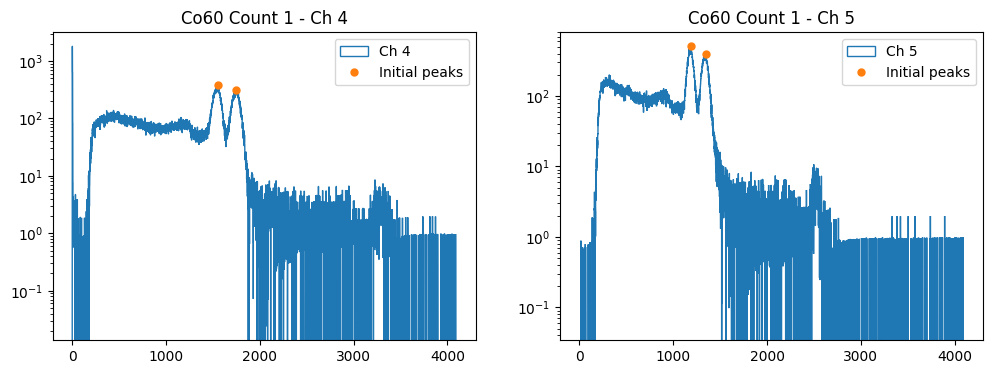

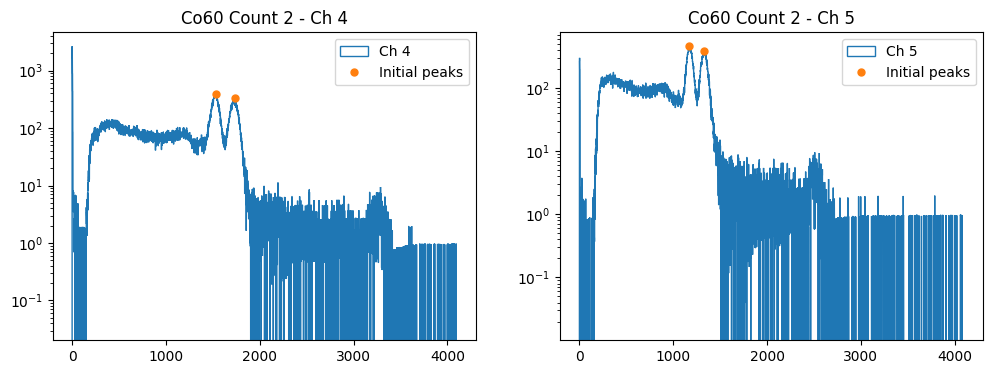

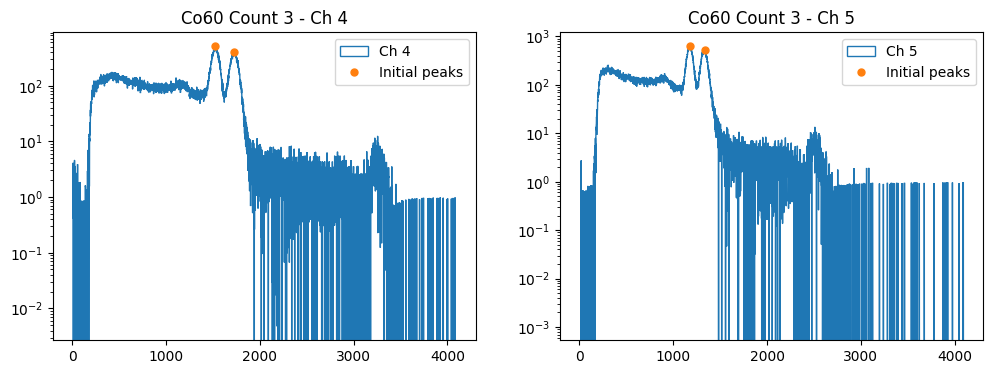

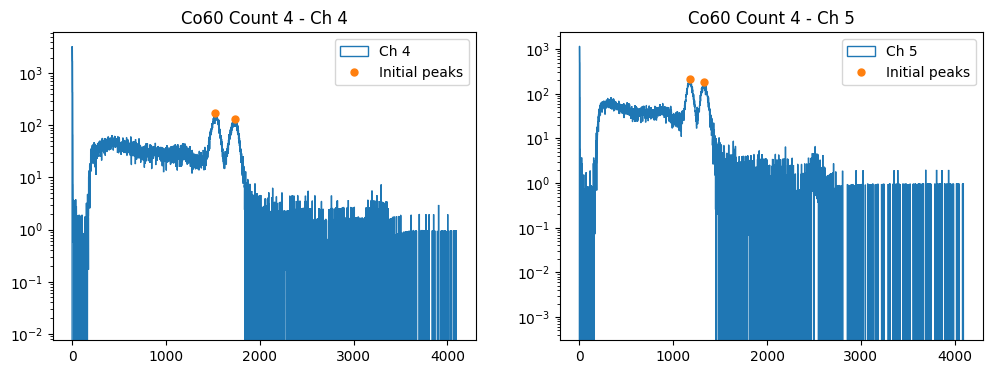

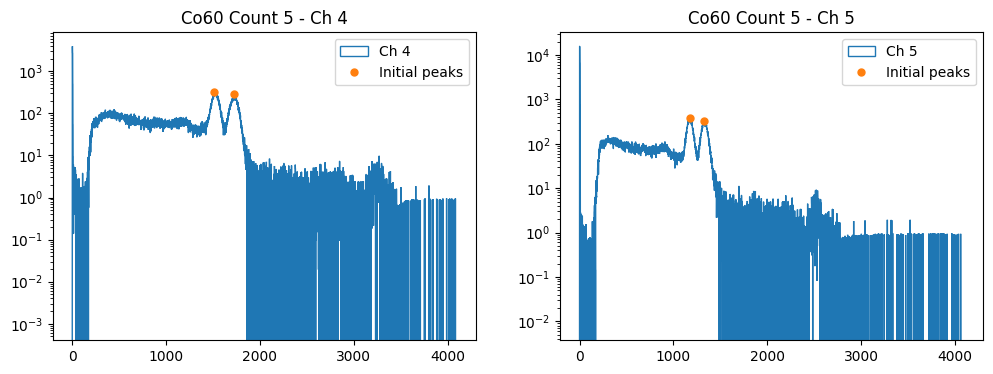

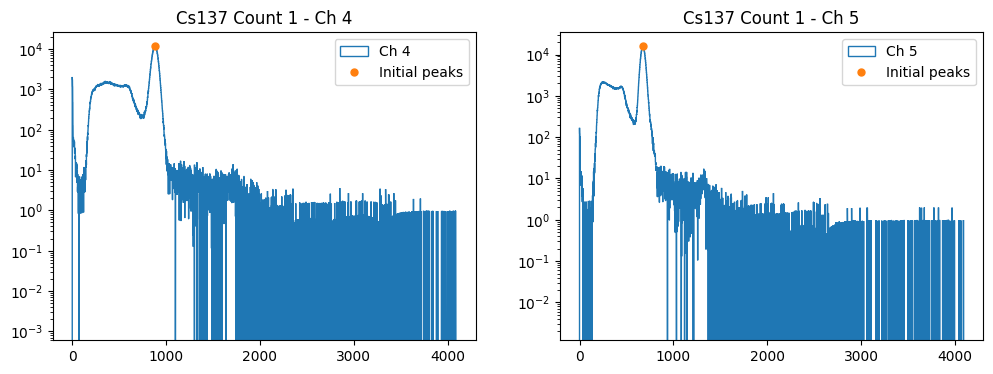

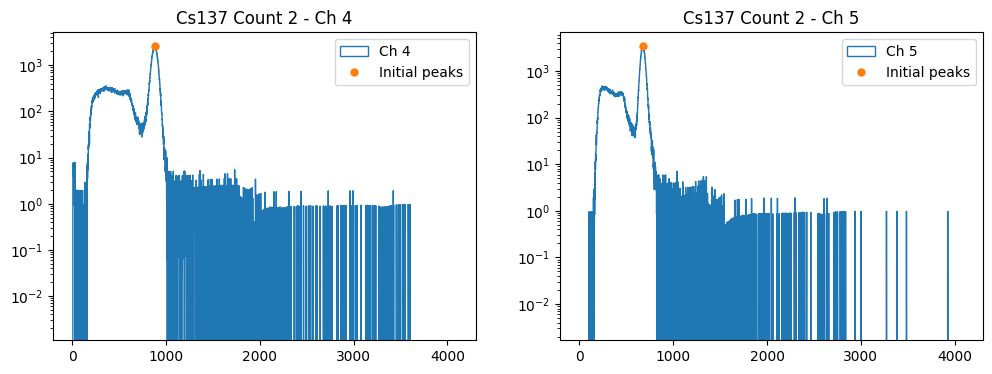

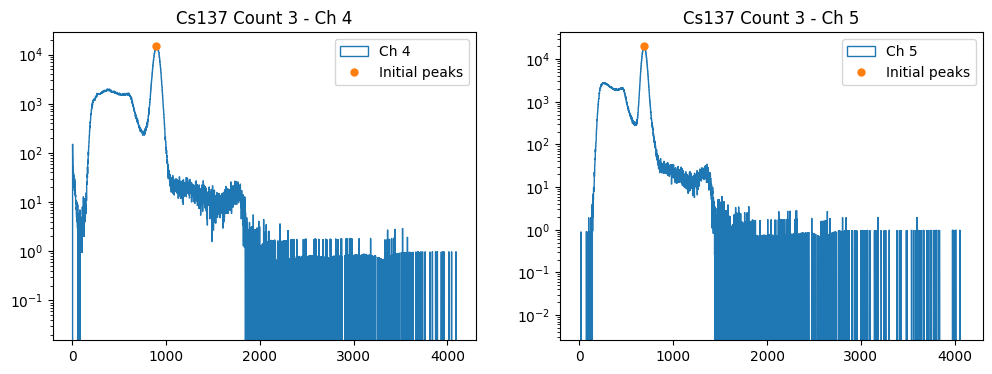

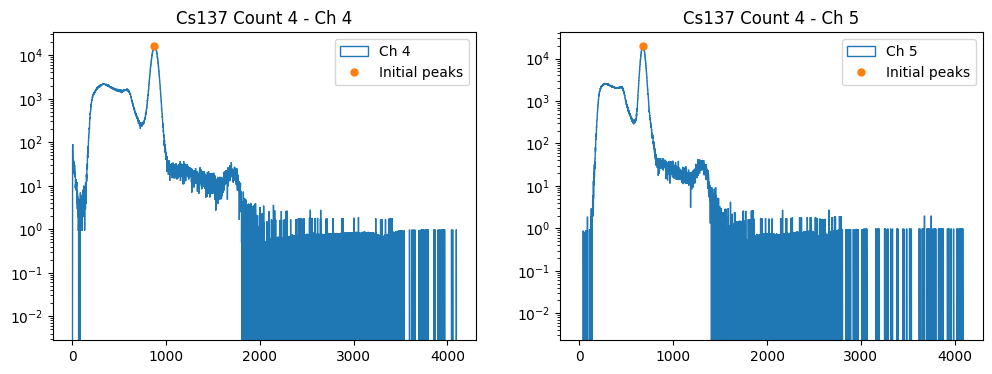

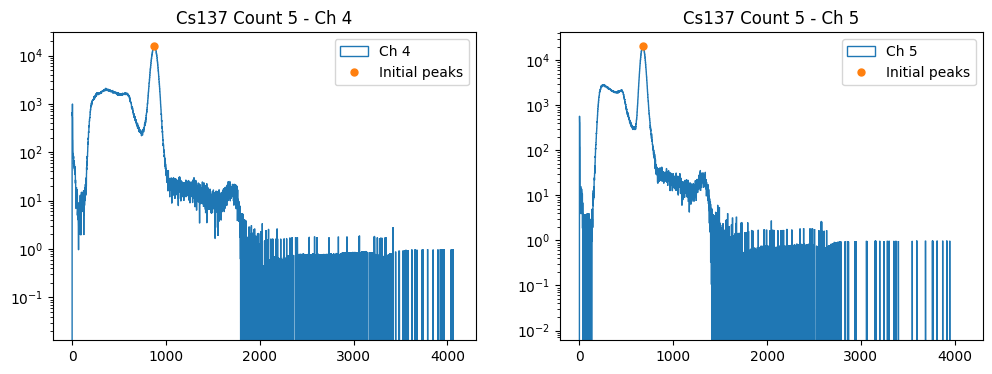

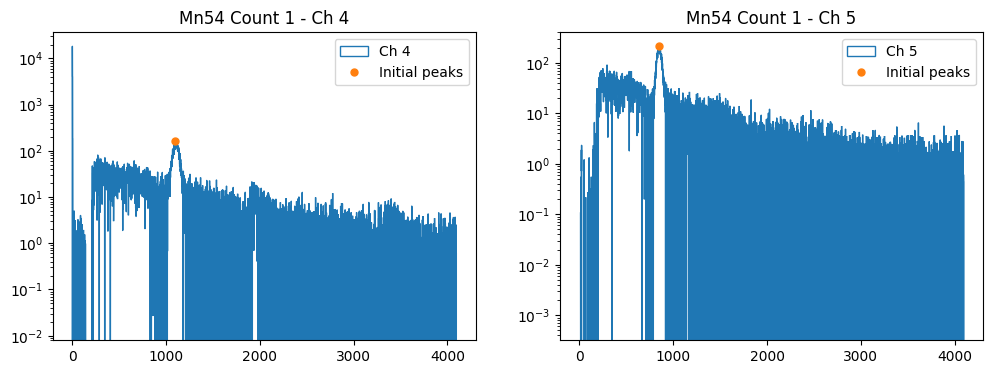

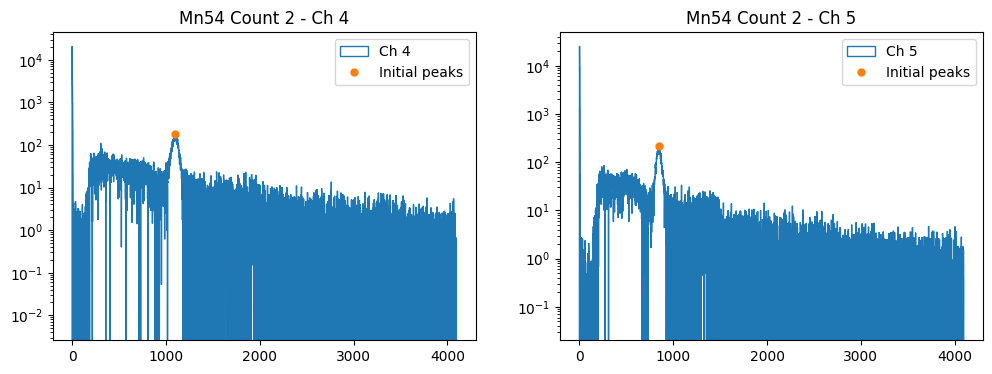

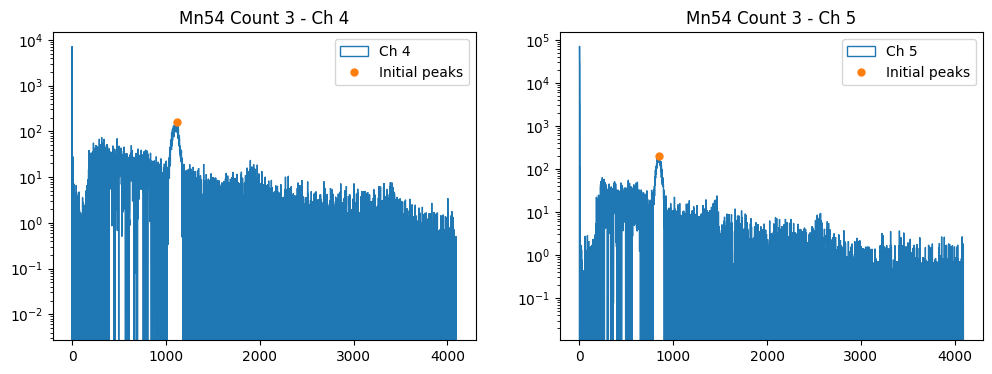

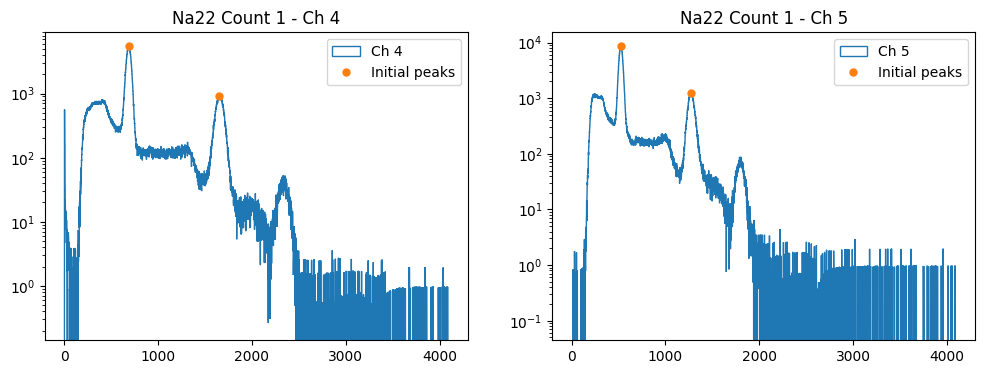

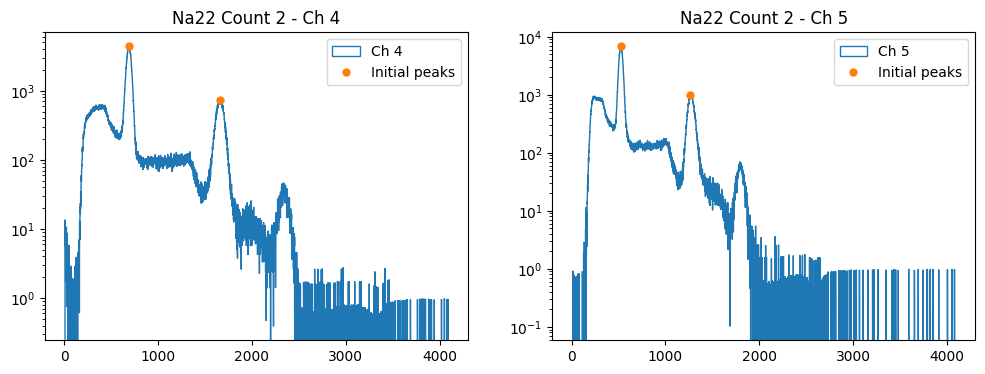

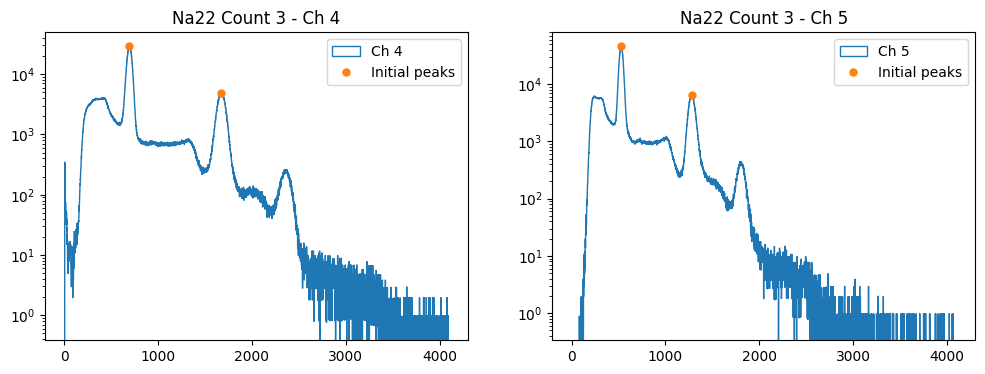

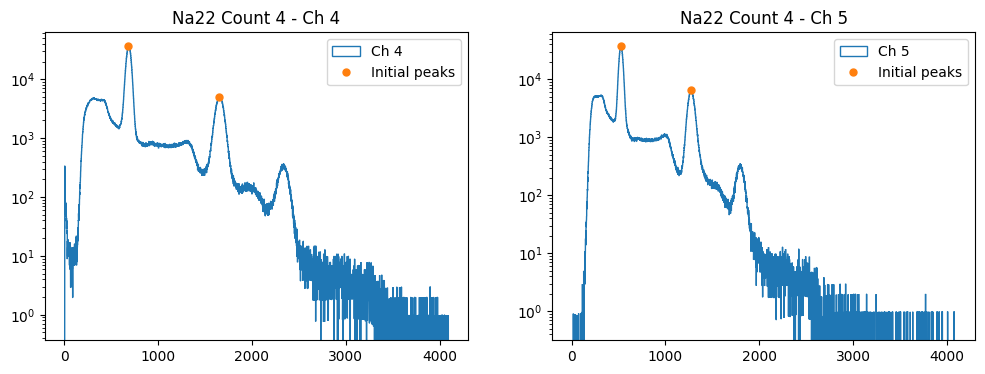

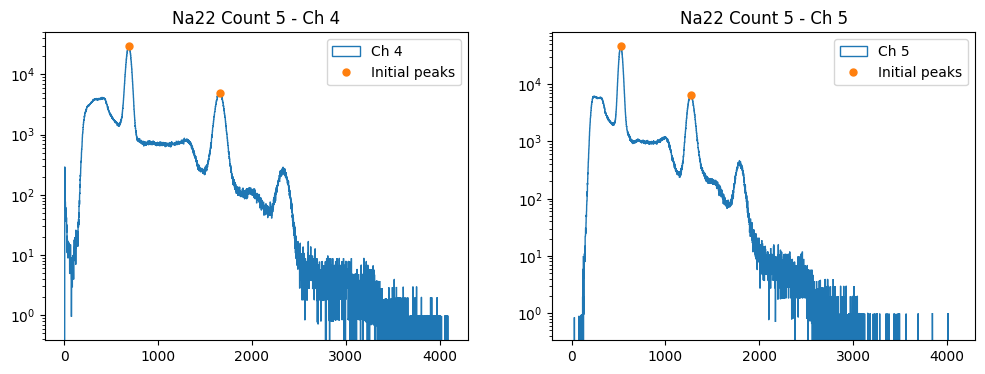

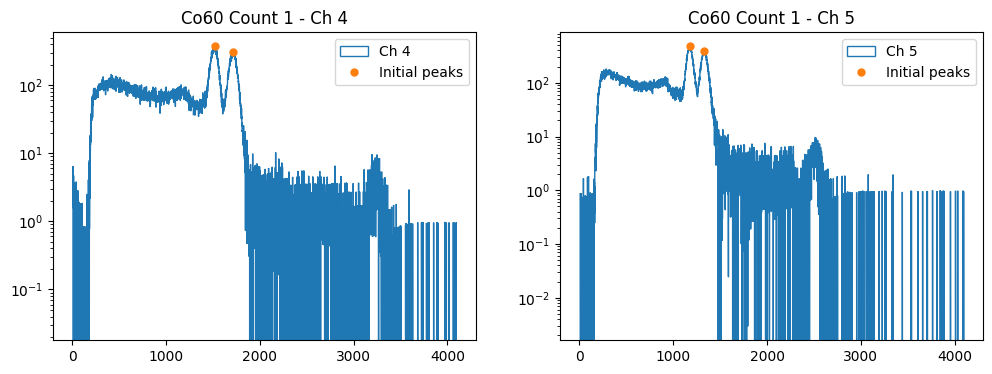

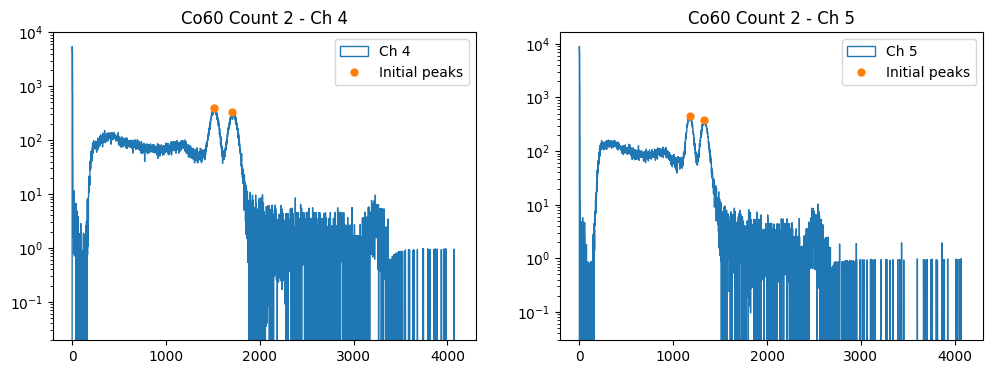

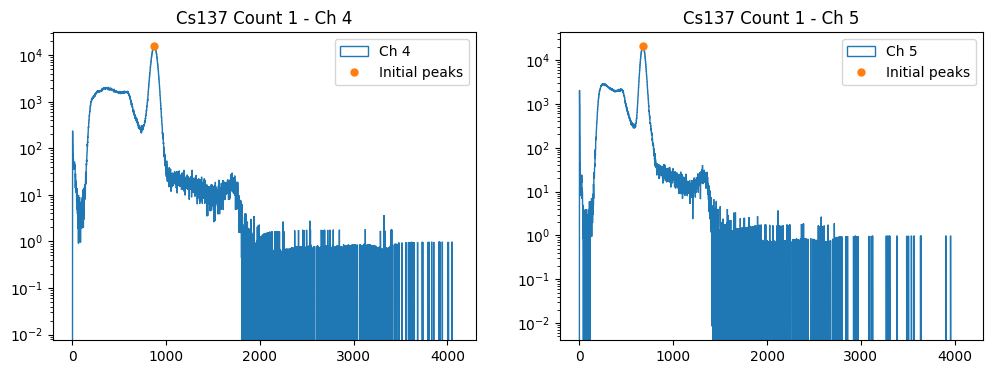

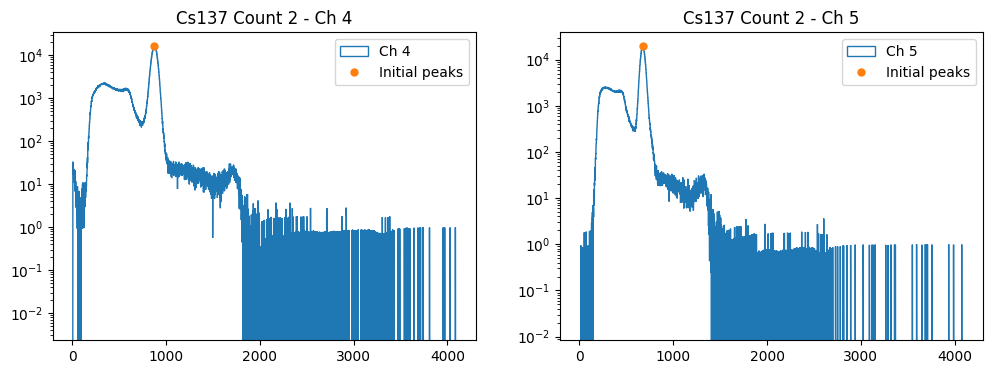

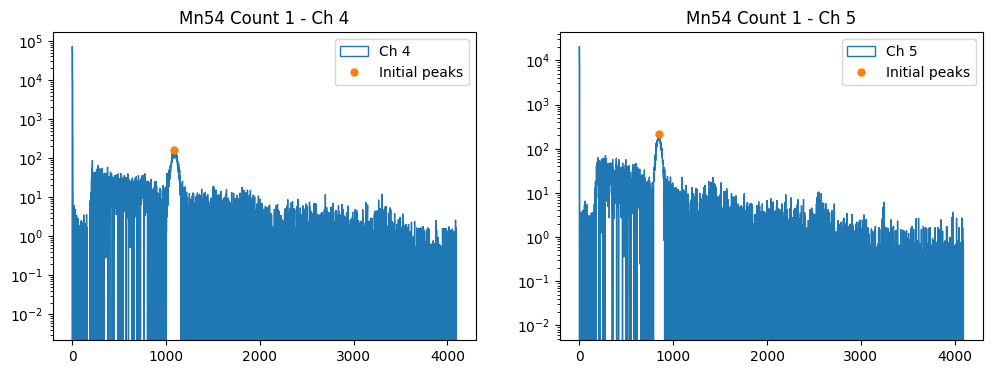

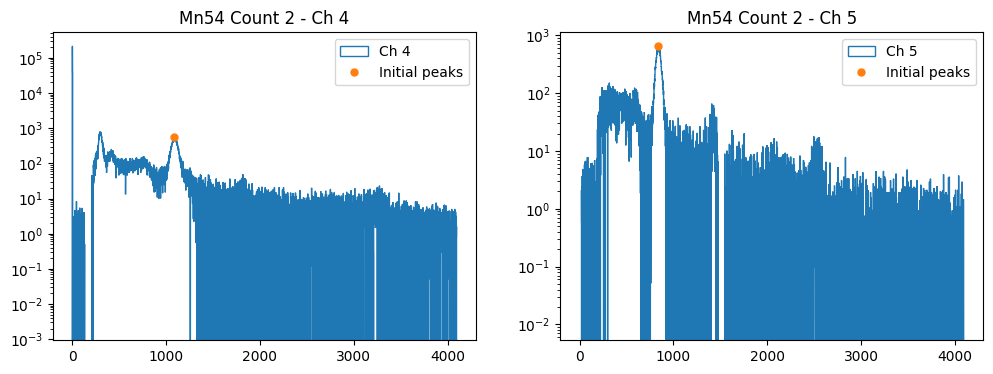

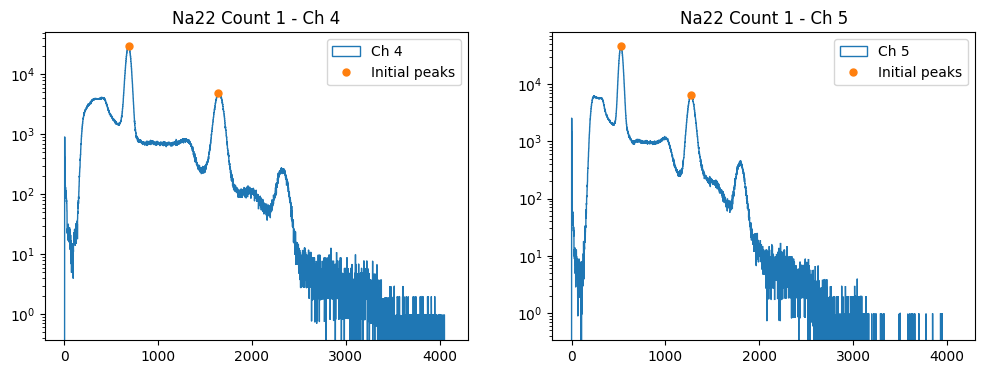

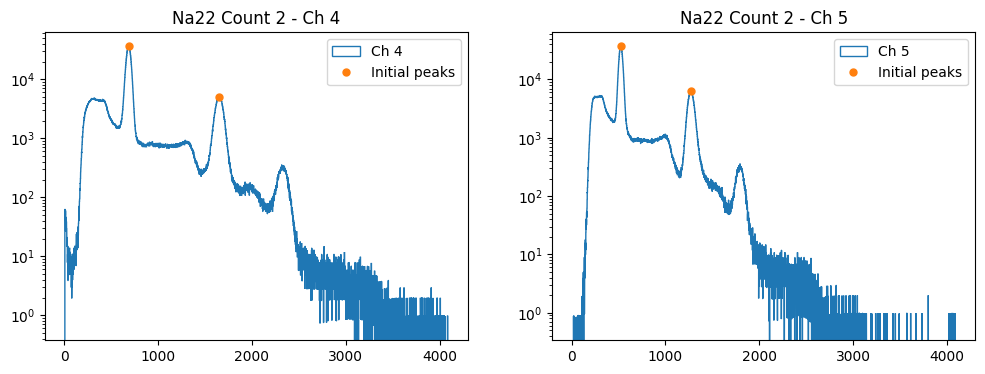

In [5]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass
from scipy.signal import find_peaks

for i in range(len(check_source_measurements)):
    bg_meas = background_meas[i]
    calibration_channels = {4: [], 5: []}
    calibration_energies = {4: [], 5: []}
    for meas_name, meas in check_source_measurements[i].items():
        fig, ax = plt.subplots(nrows=1, ncols=len(meas.detectors), figsize=(12, 4))
        for d,detector in enumerate(meas.detectors):
            hist, bin_edges = detector.get_energy_hist_background_substract(
                background_detector=bg_meas.get_detector(detector.channel_nb),
            )

            ax[d].hist(
                bin_edges[:-1],
                bins=bin_edges,
                weights=hist,
                histtype="step",
                label=f"Ch {detector.channel_nb}",
            )
            peak_kwargs = get_peak_kwargs(meas.check_source.nuclide.name, 
                                        hist)
            if peak_kwargs:
                peaks_ind = meas.get_peaks(hist, **peak_kwargs)
            else:
                peaks_ind = meas.get_peaks(hist)

            ax[d].plot(bin_edges[peaks_ind], hist[peaks_ind], "o", ms=5, label="Initial peaks")

            peaks = bin_edges[peaks_ind]

            if len(peaks) != len(meas.check_source.nuclide.energy):
                raise ValueError(
                    f"SciPy find_peaks() found {len(peaks)} photon peaks, while {len(meas.check_source.nuclide.energy)} were expected"
                )
            calibration_channels[detector.channel_nb] += list(peaks)
            calibration_energies[detector.channel_nb] += meas.check_source.nuclide.energy

            ax[d].legend()
            ax[d].set_yscale("log")
            # ax[d].set_ylim(top=2100)
            ax[d].set_title(f"{meas_name} - Ch {detector.channel_nb}")
plt.show()

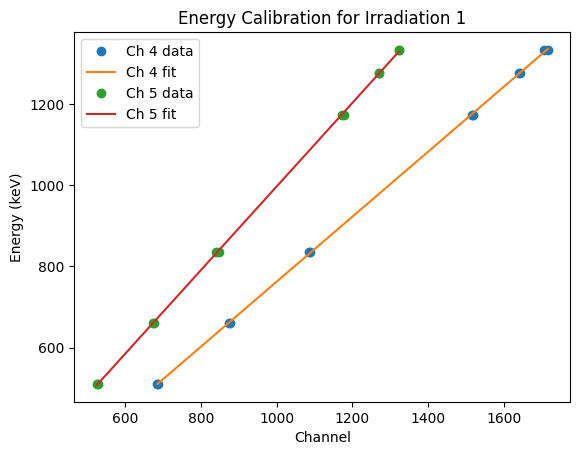

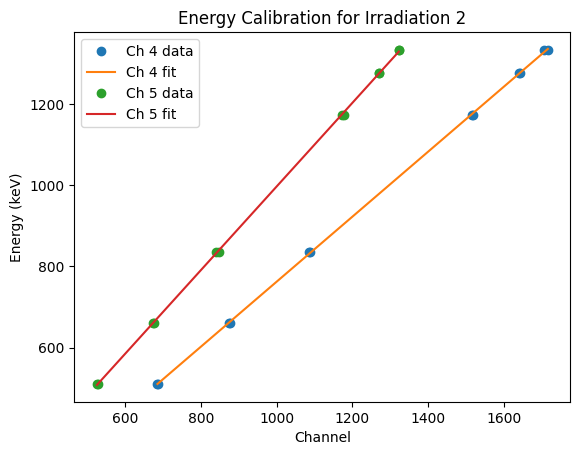

In [6]:
calibration_coeffs = []
for i in range(len(check_source_measurements)):
    calibration_coeffs_dict = {}
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for ch in calibration_channels.keys():
        sort_inds = np.argsort(calibration_channels[ch])
        calibration_channels[ch] = np.array(calibration_channels[ch])[sort_inds]
        calibration_energies[ch] = np.array(calibration_energies[ch])[sort_inds]
        coeffs = np.polyfit(calibration_channels[ch], calibration_energies[ch], deg=1)
        calibration_coeffs_dict[ch] = coeffs

        ax.plot(
            calibration_channels[ch],
            calibration_energies[ch],
            "o",
            label=f"Ch {ch} data",
        )
        xvals = np.linspace(min(calibration_channels[ch]), max(calibration_channels[ch]), 100)
        ax.plot(
            xvals,
            np.polyval(coeffs, xvals),
            "-",
            label=f"Ch {ch} fit",
        )
    calibration_coeffs.append(calibration_coeffs_dict)
    
    ax.set_xlabel("Channel")
    ax.set_ylabel("Energy (keV)")
    ax.legend()
    ax.set_title(f"Energy Calibration for Irradiation {i+1}")

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [7]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

Ch 4 
	 Energies: [ 511.     511.     511.     511.     511.     661.657  661.657  661.657
  661.657  661.657  834.848  834.848  834.848 1173.228 1173.228 1173.228
 1173.228 1173.228 1274.537 1274.537 1274.537 1274.537 1274.537 1332.492
 1332.492 1332.492 1332.492 1332.492], 
	 Efficiencies: [0.02705367 0.02155255 0.01886768 0.01891916 0.02145864 0.02112429
 0.02011178 0.0191871  0.01944135 0.02000577 0.01524255 0.016411
 0.01517907 0.01026024 0.01091442 0.01122945 0.01037728 0.01057342
 0.00964871 0.00962308 0.01095842 0.01124993 0.01099316 0.01096563
 0.00990118 0.01005087 0.00985711 0.01051393]
[-621.32578987  276.56822892  -41.12716862    2.02945482]
Ch 5 
	 Energies: [ 511.     511.     511.     511.     511.     661.657  661.657  661.657
  661.657  661.657  834.848  834.848  834.848 1173.228 1173.228 1173.228
 1173.228 1173.228 1274.537 1274.537 1274.537 1274.537 1274.537 1332.492
 1332.492 1332.492 1332.492 1332.492], 
	 Efficiencies: [0.02700076 0.03375289 0.02956208 0.02941585

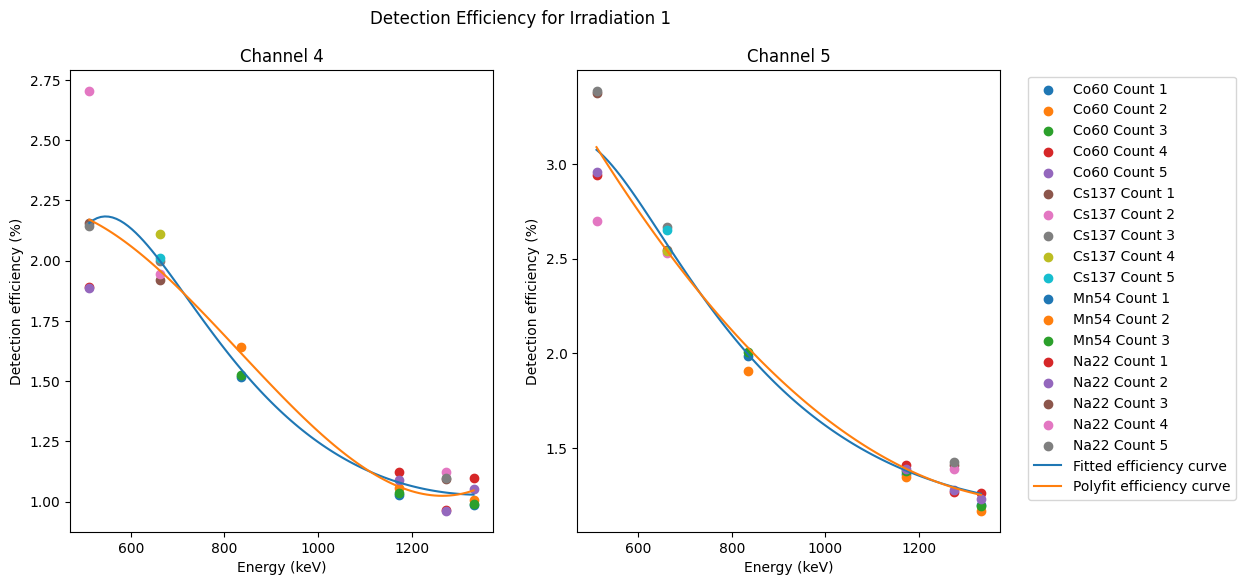

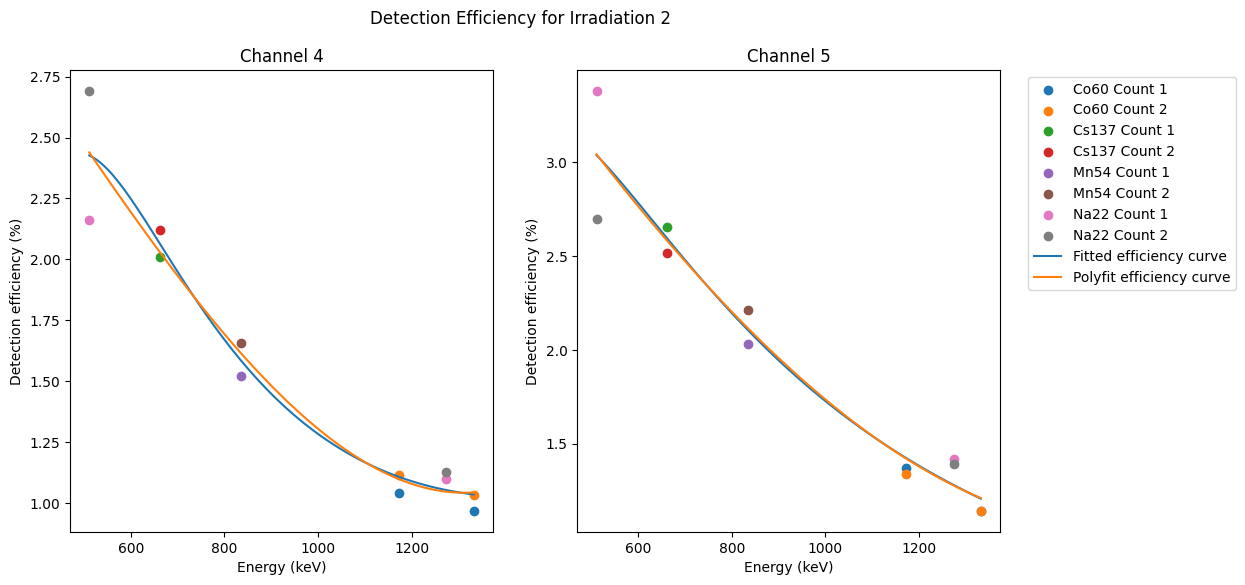

In [8]:
from scipy.optimize import curve_fit

efficiency_coeffs = []
for i in range(len(check_source_measurements)):
    channels = []
    efficiency_coeffs_dict = {}
    measurement = list(check_source_measurements[i].values())[0]
    search_width = 320

    for detector in measurement.detectors:
        channels.append(detector.channel_nb)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for c,ch in enumerate(channels):
        background_detector = background_meas[i].get_detector(ch)
        energies = []
        efficiencies = []
        for name, measurement in check_source_measurements[i].items():
            check_source_detector = measurement.get_detector(ch)
            hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
            calibrated_bin_edges = np.polyval(calibration_coeffs[i][ch], bin_edges)
            
            efficiency = measurement.compute_detection_efficiency(
                background_measurement=background_meas[i],
                calibration_coeffs=calibration_coeffs[i][ch],
                channel_nb=ch,
                search_width=search_width,
            )
            energies += measurement.check_source.nuclide.energy
            efficiencies += list(efficiency)
            ax[c].scatter(
                measurement.check_source.nuclide.energy,
                efficiency * 100,
                label=name,
            )

        # Sort energies and efficiencies for fitting
        sorted_indices = np.argsort(energies)
        energies = np.array(energies)[sorted_indices]
        efficiencies = np.array(efficiencies)[sorted_indices]
        print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

        # Fit the efficiency curve
        popt, pcov = curve_fit(
            eff_curve_func,
            energies,
            efficiencies,
            p0=[-1, 1, 0, 0],
        )

        poly_coeff = np.polyfit(energies, efficiencies, 3)
        efficiency_coeffs_dict[ch] = poly_coeff
        xs = np.linspace(
            energies[0],
            energies[-1],
            100,
        )
        ax[c].plot(
            xs,
            eff_curve_func(xs, *popt) * 100,
            label="Fitted efficiency curve",
        )

        ax[c].plot(
            xs,
            np.polyval(poly_coeff, xs) * 100,
            label="Polyfit efficiency curve",
        )
        ax[c].set_xlabel("Energy (keV)")
        ax[c].set_ylabel("Detection efficiency (%)")
        ax[c].set_title(f"Channel {ch}")
        # plt.ylim(bottom=0)
        print(popt)
    ax[c].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    efficiency_coeffs.append(efficiency_coeffs_dict)
    fig.suptitle(f"Detection Efficiency for Irradiation {i+1}")
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [9]:
all_neutron_rates = {}
all_neutron_rates_err = {}

In [10]:
from process_foil_data import irradiation_dict, time_generator_off_dict

### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the various measurements of the Niobium Packet #3 after irradiation are used to calculate the neutron rate of the overall irradiation. 

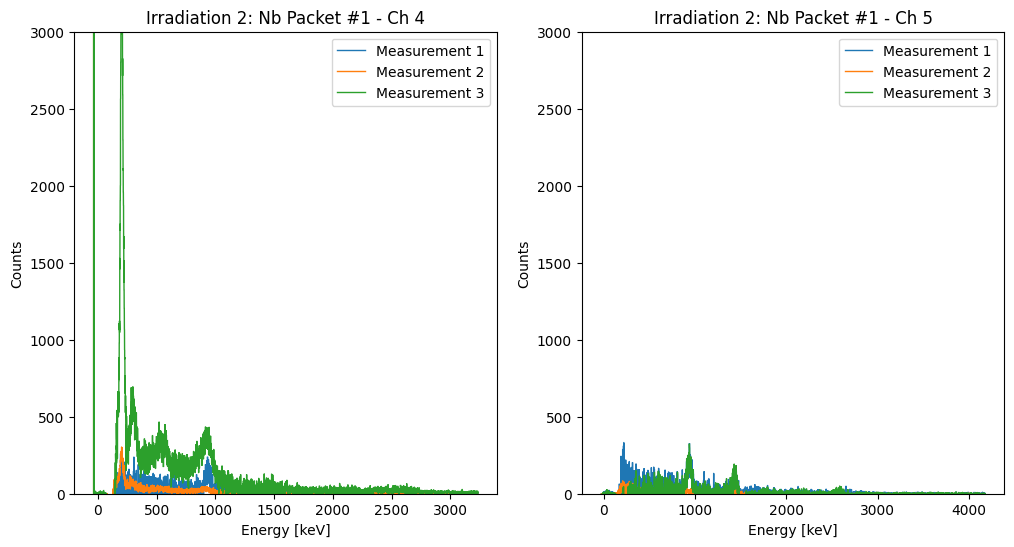

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for c,ch in enumerate([4, 5]):
    for m,meas in enumerate(foil_measurements[-1]['Irradiation 2: Nb Packet #1']['measurements'].values()):
        detector = meas.get_detector(ch)
        hist, bin_edges = detector.get_energy_hist_background_substract(
            background_detector=background_meas[-1].get_detector(ch),
        )
        bin_edges = np.polyval(calibration_coeffs[-1][ch], bin_edges)
        ax[c].stairs(hist, bin_edges, label=f"Measurement {m+1}")
    ax[c].set_xlabel("Energy [keV]")
    ax[c].set_ylim(bottom=0, top=3000)
    ax[c].set_ylabel("Counts")
    ax[c].legend()
    ax[c].set_title(f"Irradiation 2: Nb Packet #1 - Ch {ch}")
plt.show()

In [11]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_names = {
    1: "Irradiation 1: Nb Packet #2",
    2: "Irradiation 2: Nb Packet #1"
}

for i,irr_ind in enumerate(irradiation_dict.keys()):
    print(f"\nIrradiation {irr_ind}: {foil_names[irr_ind]}")
    all_neutron_rates[irr_ind] = []
    all_neutron_rates_err[irr_ind] = []
    neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements[i],
                                                                        foil_names[irr_ind],
                                                                        background_meas[i],
                                                                        calibration_coeffs[i],
                                                                        efficiency_coeffs[i],
                                                                        search_width=search_width,
                                                                        irradiations=irradiation_dict[irr_ind],
                                                                        time_generator_off=time_generator_off_dict[irr_ind],)

    for count_name in neutron_rates.keys():
        print(count_name)
        for ch in np.sort(list(neutron_rates[count_name].keys())):
            neutron_rate = neutron_rates[count_name][ch]
            neutron_rate_err = neutron_rate_errs[count_name][ch]
            print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
            all_neutron_rates[irr_ind].append(neutron_rate[0])
            all_neutron_rates_err[irr_ind].append(neutron_rate_err[0])



Irradiation 1: Irradiation 1: Nb Packet #2
Count 1
	 Ch 4: Neutron rate: 8.384e+07 +/- 9.205e+05 n/s
	 Ch 5: Neutron rate: 8.861e+07 +/- 8.372e+05 n/s
Count 2
	 Ch 4: Neutron rate: 7.978e+07 +/- 6.762e+05 n/s
	 Ch 5: Neutron rate: 8.950e+07 +/- 6.334e+05 n/s
Count 3
	 Ch 4: Neutron rate: 9.009e+07 +/- 1.306e+06 n/s
	 Ch 5: Neutron rate: 9.440e+07 +/- 1.185e+06 n/s

Irradiation 2: Irradiation 2: Nb Packet #1
Count 1
	 Ch 4: Neutron rate: 8.535e+07 +/- 8.294e+05 n/s
	 Ch 5: Neutron rate: 8.472e+07 +/- 7.174e+05 n/s
Count 2
	 Ch 4: Neutron rate: 2.076e+08 +/- 5.044e+06 n/s
	 Ch 5: Neutron rate: 1.231e+08 +/- 3.373e+06 n/s
Count 3
	 Ch 4: Neutron rate: 2.207e+08 +/- 1.380e+06 n/s
	 Ch 5: Neutron rate: 9.694e+07 +/- 7.937e+05 n/s


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the various measurements of the Zirconium Packet #1 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [12]:
foil_names = {
    1: "Irradiation 1: Zr Packet #1",
    2: "Irradiation 2: Zr Packet #2"
}

for i,irr_ind in enumerate(irradiation_dict.keys()):
    print(f"\nIrradiation {irr_ind}: {foil_names[irr_ind]}")
    all_neutron_rates[irr_ind] = []
    all_neutron_rates_err[irr_ind] = []
    neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements[i],
                                                                        foil_names[irr_ind],
                                                                        background_meas[i],
                                                                        calibration_coeffs[i],
                                                                        efficiency_coeffs[i],
                                                                        search_width=search_width,
                                                                        irradiations=irradiation_dict[irr_ind],
                                                                        time_generator_off=time_generator_off_dict[irr_ind],)

    for count_name in neutron_rates.keys():
        print(count_name)
        for ch in np.sort(list(neutron_rates[count_name].keys())):
            neutron_rate = neutron_rates[count_name][ch]
            neutron_rate_err = neutron_rate_errs[count_name][ch]
            print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
            all_neutron_rates[irr_ind].append(neutron_rate[0])
            all_neutron_rates_err[irr_ind].append(neutron_rate_err[0])


Irradiation 1: Irradiation 1: Zr Packet #1
Count 1
	 Ch 4: Neutron rate: 8.074e+07 +/- 5.404e+05 n/s
	 Ch 5: Neutron rate: 7.965e+07 +/- 4.719e+05 n/s
Count 2
	 Ch 4: Neutron rate: 7.892e+07 +/- 4.581e+05 n/s
	 Ch 5: Neutron rate: 7.837e+07 +/- 4.039e+05 n/s
Count 3
	 Ch 4: Neutron rate: 7.522e+07 +/- 5.383e+05 n/s
	 Ch 5: Neutron rate: 7.873e+07 +/- 4.885e+05 n/s

Irradiation 2: Irradiation 2: Zr Packet #2
Count 1
	 Ch 4: Neutron rate: 8.280e+07 +/- 5.952e+05 n/s
	 Ch 5: Neutron rate: 8.064e+07 +/- 5.108e+05 n/s
Count 2
	 Ch 4: Neutron rate: 8.131e+07 +/- 9.067e+05 n/s
	 Ch 5: Neutron rate: 7.864e+07 +/- 7.754e+05 n/s


### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [13]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

In [ ]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")